In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import regex as re

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation
%matplotlib inline

Using TensorFlow backend.


### loading preprocessed dataset

In [2]:
df = pd.read_csv('C:/Users/Gj/Documents/Git/macedonian_stock_exchange_market/tmp/mse_raw.csv', parse_dates=['date', 'start_date'], index_col='Unnamed: 0')

In [3]:
df.head(5)

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


## feature engineering

In [4]:
# dates - (year, month, day etc...)
# rolling - (QTY, volume, volumne total etc...) depend on target (1day, 7days, 30days up to 1 year)
# target closing price - (1day, 7days, 30days, 2months etc)
# target QTY - (1day, 7days, 30days, 2months etc)

In [5]:
df_final = df.copy()

In [6]:
def display_all(df):
    with pd.option_context("display.max_rows", 10000, "display.max_columns", 10000): 
        display(df)

### date extraction

In [7]:
df_final['sale_year'] = df_final.date.dt.year
df_final['sale_month'] = df_final.date.dt.month
df_final['sale_week'] = df_final.date.dt.week
df_final['sale_day'] = df_final.date.dt.day
df_final['sale_dayofweek'] = df_final.date.dt.dayofweek
df_final['sale_dayofyear'] = df_final.date.dt.dayofyear
df_final['is_month_end'] = df_final.date.dt.is_month_end
df_final['is_month_start'] = df_final.date.dt.is_month_start
df_final['is_quarter_end'] = df_final.date.dt.is_quarter_end
df_final['is_quarter_start'] = df_final.date.dt.is_quarter_start
df_final['is_year_end'] = df_final.date.dt.is_year_end
df_final['is_year_start'] = df_final.date.dt.is_year_start
df_final['days_in_month'] = df_final.date.dt.days_in_month
df_final['is_leap_year'] = df_final.date.dt.is_leap_year
df_final['sales_elapsed'] = df_final.date - df_final.start_date
df_final['sales_elapsed'] = df_final.sales_elapsed.dt.days

In [8]:
display_all(df_final.tail(2))

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date,sale_year,sale_month,sale_week,sale_day,sale_dayofweek,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed
189837,VITA,2020-08-24,14080.0,14080.0,14080.0,14080.0,14080.0,0.0,0.0,0.0,0.0,1998-10-13,2020,8,35,24,0,237,False,False,False,False,False,False,31,True,7986
189859,VITA,2020-08-25,14080.0,14080.0,14080.0,14080.0,14080.0,0.0,0.0,0.0,0.0,1998-10-13,2020,8,35,25,1,238,False,False,False,False,False,False,31,True,7987


### rolling

In [9]:
df_final = df_final.set_index('date')

In [10]:
df_final.head(3)

,stock_id,open,high,low,average,close,volume,quantity,change %,volume total,...,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed
date,,,,,,,,,,,,,,,,,,,,,
1997-01-09,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,...,9,False,False,False,False,False,False,31,False,0
1997-01-10,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,10,False,False,False,False,False,False,31,False,1
1997-01-11,ALK,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,...,11,False,False,False,False,False,False,31,False,2


In [11]:
#rolloing list for 7 days target shifted by 7 days
sum_7_qty_by_stock = []
volumne_moving_avg_7 = []
close_moving_avg_7 = []
close_volatility_7 = []
max_7_days = []
min_7_days = []
change_by_stock_daily_prev = []
profitability_daily_prev = []
ratio_prev = []

In [12]:
for stock in df_final.stock_id.unique():
    # sum quantity over last 7 days
    qty_sum_7 = df_final[df_final.stock_id == stock].quantity.shift(7).rolling(7).sum()
    sum_7_qty_by_stock.append(qty_sum_7)
    # moving average on volumne over last 7 days
    volumne_ma_7 = df_final[df_final.stock_id == stock].volume.shift(7).rolling(7).mean()
    volumne_moving_avg_7.append(volumne_ma_7)
    # moving average on close price over last 7 days
    close_ma_7 = df_final[df_final.stock_id == stock].close.shift(7).rolling(7).mean()
    close_moving_avg_7.append(close_ma_7)
    # volatility in close price over last 7 days
    close_volatility_7_by_stock = df_final[df_final.stock_id == stock].close.shift(7).rolling(7).std() #shift()
    close_volatility_7.append(close_volatility_7_by_stock)
    # max close price in last 7 days
    max_7_by_stock = df_final[df_final.stock_id == stock].close.shift(7).rolling(7).max()
    max_7_days.append(max_7_by_stock)
    # min close price in last 7 days
    min_7_by_stock = df_final[df_final.stock_id == stock].close.shift(7).rolling(7).min()
    min_7_days.append(min_7_by_stock)
    # ratio overall will be average price devided by max closing price over all time
    mean_close_price = df_final[df_final.stock_id == stock].close.shift(7).mean()
    ratio_by_stock_prev = df_final[df_final.stock_id == stock].close.shift(7) / mean_close_price
    ratio_prev.append(ratio_by_stock_prev)
    
    # daily_change new feature
    today = df_final[df_final.stock_id == stock].close.shift(7)
    yesterday = today.shift(8)
    change_by_stock =  today / yesterday - 1
    change_by_stock_daily_prev.append(change_by_stock)
    
    # daily_profitability_prev new feature
    profitability_by_stock_prev = df_final[df_final.stock_id == stock].close.shift(7) - df_final[df_final.stock_id == stock].open.shift(7)
    profitability_daily_prev.append(profitability_by_stock_prev)

In [13]:
chain_object_1 = itertools.chain.from_iterable(sum_7_qty_by_stock)
flattened_list_1 = list(chain_object_1)

chain_object_3 = itertools.chain.from_iterable(volumne_moving_avg_7)
flattened_list_3 = list(chain_object_3)

chain_object_5 = itertools.chain.from_iterable(close_moving_avg_7)
flattened_list_5 = list(chain_object_5)

chain_object_7 = itertools.chain.from_iterable(close_volatility_7)
flattened_list_7 = list(chain_object_7)

chain_object_9 = itertools.chain.from_iterable(max_7_days)
flattened_list_9 = list(chain_object_9)

chain_object_11 = itertools.chain.from_iterable(min_7_days)
flattened_list_11 = list(chain_object_11)

ratio_object = itertools.chain.from_iterable(ratio_prev)
flattened_list_13 = list(ratio_object)

change_daily_object = itertools.chain.from_iterable(change_by_stock_daily_prev)
flattened_list_14 = list(change_daily_object)

profitability_object = itertools.chain.from_iterable(profitability_daily_prev)
flattened_list_15 = list(profitability_object)

In [14]:
rolling_7_days = pd.DataFrame({'sum_7_qty_by_stock':flattened_list_1,
                               'moving_avg_volume_7_days':flattened_list_3,
                               'moving_avg_close_7_days':flattened_list_5,
                               'volatility_7_days':flattened_list_7,
                               'max_7_days':flattened_list_9,
                               'min_7_days':flattened_list_11,
                               'ratio_overall_prev':flattened_list_13,
                               'change_daily_prev':flattened_list_14,
                               'profitability_daily_prev':flattened_list_15
                              }
                             )

In [15]:
print(df_final.shape, rolling_7_days.shape)

(164754, 26) (164754, 9)


In [16]:
df_7_days = pd.concat([df_final.reset_index(), rolling_7_days], axis=1)

In [17]:
len(df_7_days.columns)

36

In [18]:
ratio_7_days = []

# Calculating ratios up to 7 days
for stock in df_7_days.stock_id.unique():
    ratio_7 = df_7_days[df_7_days.stock_id == stock].average.shift(7) / df_7_days[df_7_days.stock_id == stock].average.shift(7).mean()
    ratio_7_days.append(ratio_7)


In [19]:
chain_object_16 = itertools.chain.from_iterable(ratio_7_days)
flattened_list_16 = list(chain_object_16)

ratios_df = pd.DataFrame({'ratio_7_days':flattened_list_16
                         }
                        )

In [20]:
df_7_days = pd.concat([df_7_days, ratios_df], axis=1)

In [21]:
len(df_7_days.columns)

37

In [22]:
### Add column based on data analysis

# 1 day
df_7_days['prevopen_1'] = df_7_days.groupby(['stock_id'])['open'].shift(7)
#(open - prevopen) / prevopen
df_7_days['returnsOpenPrevRaw1'] = (df_7_days.open.shift(8) - df_7_days.prevopen_1) / df_7_days.prevopen_1

#10 days
df_7_days['prevopen_7'] = df_7_days.groupby(['stock_id'])['open'].shift(14)
df_7_days['returnsOpenPrevRaw_7'] = (df_7_days.open.shift(7) - df_7_days.prevopen_7) / df_7_days.prevopen_7

#Rate of change

# pct_chg = lambda x:x.pct_change()
# df_7_days['pct'] = df_7_days.groupby(['stock_id'])['close'].apply(pct_chg)

#Z-score
# zscore = lambda x:(x-x.mean())/x.std()
# df_7_days['z_score'] = df_7_days.groupby(['stock_id'])['close'].apply(zscore)

#percentile transformation
#rollrank = lambda x: x.rolling(200, min_periods=20).apply(lambda x:pd.Series(x).rank(pct=True)[0])
#df_7_days['percentile'] = df_7_days.groupby(['stock_id'])['volume'].apply(rollrank)

In [23]:
display_all(df_7_days[df_7_days.stock_id=='ALK'].tail(5).T)

,8625,8626,8627,8628,8629
date,2020-08-21 00:00:00,2020-08-22 00:00:00,2020-08-23 00:00:00,2020-08-24 00:00:00,2020-08-25 00:00:00
stock_id,ALK,ALK,ALK,ALK,ALK
open,12223,12290,12290,12290,12290
high,12290,12290,12290,12290,12222
low,12289,12290,12290,12289,12200
average,12289.5,12290,12290,12289.7,12201.5
close,12290,12290,12290,12290,12200
volume,614476,0,0,73738,3.66044e+06
quantity,50,0,0,6,300
change %,-0.05,0,0,0,-0.72


### setting ALK dataset for training, validation and test

In [24]:
alk_df = df_7_days[df_7_days.stock_id == 'ALK']

In [25]:
to_drop = ['date','start_date', 'stock_id', 'open', 'high', 'low', 'average', 'volume', 'quantity', 'change %', 'volume total']

In [26]:
alk_df = alk_df.dropna()

In [27]:
alk_df.drop(to_drop, axis=1, inplace=True)

In [28]:
len(alk_df.columns)

30

In [29]:
alk_df['close_shift'] = alk_df['close'].shift(7)

In [30]:
alk_df = alk_df.dropna()

In [31]:
display_all(alk_df.head(5))

,close,sale_year,sale_month,sale_week,sale_day,sale_dayofweek,sale_dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start,days_in_month,is_leap_year,sales_elapsed,sum_7_qty_by_stock,moving_avg_volume_7_days,moving_avg_close_7_days,volatility_7_days,max_7_days,min_7_days,ratio_overall_prev,change_daily_prev,profitability_daily_prev,ratio_7_days,prevopen_1,returnsOpenPrevRaw1,prevopen_7,returnsOpenPrevRaw_7,close_shift
22,1000.0,1997,1,5,31,4,31,True,False,False,False,False,False,31,False,22,478.0,69101.428571,1018.571429,10.690450,1030.0,1010.0,0.227561,-0.019417,0.0,0.227561,1010.0,0.0,1030.0,-0.019417,1010.0
23,1000.0,1997,2,5,1,5,32,False,True,False,False,False,False,28,False,23,478.0,69101.428571,1015.714286,9.759001,1030.0,1010.0,0.227561,-0.019417,0.0,0.227561,1010.0,0.0,1030.0,-0.019417,1010.0
24,1000.0,1997,2,5,2,6,33,False,False,False,False,False,False,28,False,24,478.0,69101.428571,1012.857143,7.559289,1030.0,1010.0,0.227561,-0.019417,0.0,0.227561,1010.0,0.0,1030.0,-0.019417,1010.0
25,1000.0,1997,2,6,3,0,34,False,False,False,False,False,False,28,False,25,478.0,69101.428571,1010.000000,0.000000,1010.0,1010.0,0.227561,-0.019417,0.0,0.227561,1010.0,0.0,1030.0,-0.019417,1010.0
26,1000.0,1997,2,6,4,1,35,False,False,False,False,False,False,28,False,26,707.0,101675.714286,1008.571429,3.779645,1010.0,1000.0,0.225308,-0.029126,-10.0,0.225308,1010.0,0.0,1030.0,-0.019417,1000.0


### split dataset

In [32]:
X, y = alk_df.drop(['close', 'close_shift'], axis=1), alk_df.close_shift
#X, y = alk_df_scaled[1:], alk_df_scaled[0]

In [33]:
def split_vals(dataset, n_test):
    n = dataset.shape[0] - n_test
    train_valid = dataset[:n].copy()
    return train_valid[:-n_test].copy(), train_valid[-n_test:n].copy(), dataset[-n_test:]

n_test = 7
X_train, X_valid, X_test = split_vals(X, n_test)
y_train, y_valid, y_test = split_vals(y, n_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8594, 29), (7, 29), (7, 29), (8594,), (7,), (7,))

In [34]:
import math

def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

def print_score(model, X_train, y_train, X_valid, y_valid):
    res = [np.sqrt(mean_squared_error(model.predict(X_train), y_train)), 
           np.sqrt(mean_squared_error(model.predict(X_valid), y_valid)),
           model.score(X_train, y_train),
           model.score(X_valid, y_valid)]
    if hasattr(model, 'oob_score_'):
        res.append(model.oob_score_)
    print(res)

### Fine-tune RandomForestRegressor

In [35]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

Wall time: 1.31 s
[6.059778319585853, 28.747065067585716, 0.9999957273874963, 0.88262813405797, 0.9999675465069678]


In [36]:
preds = np.stack([t.predict(X_valid) for t in model.estimators_])
#print(f"Trees: {len(preds[:,0])},", f"Mean of 0th row for prediction from all trees: : {np.mean(preds[:,0])},", f"Actual y: {y_valid[0]}")

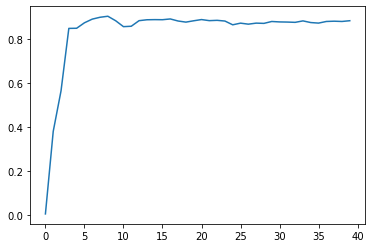

In [37]:
from sklearn import metrics
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(40)]);

In [38]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [39]:
fi = rf_feat_importance(model, X_train)
fi[:10]

,cols,imp
21,ratio_overall_prev,0.375120
24,ratio_7_days,0.300041
25,prevopen_1,0.123731
20,min_7_days,0.075631
17,moving_avg_close_7_days,0.063907
19,max_7_days,0.060757
27,prevopen_7,0.000451
14,sales_elapsed,0.000255
23,profitability_daily_prev,0.000023
0,sale_year,0.000015


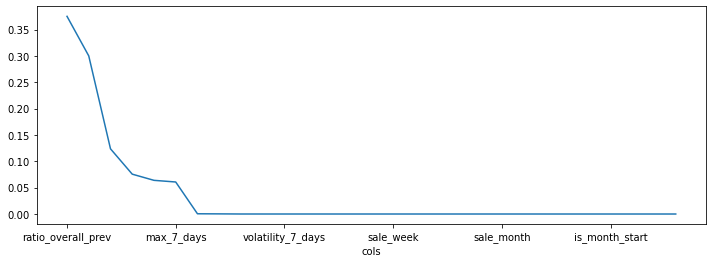

In [40]:
fi.plot('cols', 'imp', figsize=(12,4), legend=False);

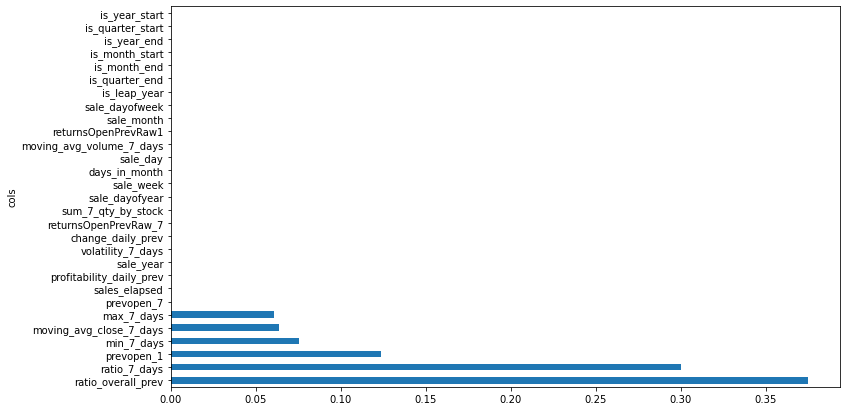

In [41]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30])

In [42]:
to_keep = fi[fi.imp>0.005].cols;
len(to_keep)

6

In [43]:
df_keep = alk_df[to_keep].copy()
X_train_keep, X_valid_keep, X_test_keep = split_vals(df_keep, n_test)

In [44]:
model_keep = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_keep.fit(X_train_keep, y_train)
print_score(model_keep, X_train_keep, y_train, X_valid_keep, y_valid)

Wall time: 606 ms
[5.917734149726347, 24.256155330731627, 0.9999959253441382, 0.9164356739130421, 0.9999689711083769]


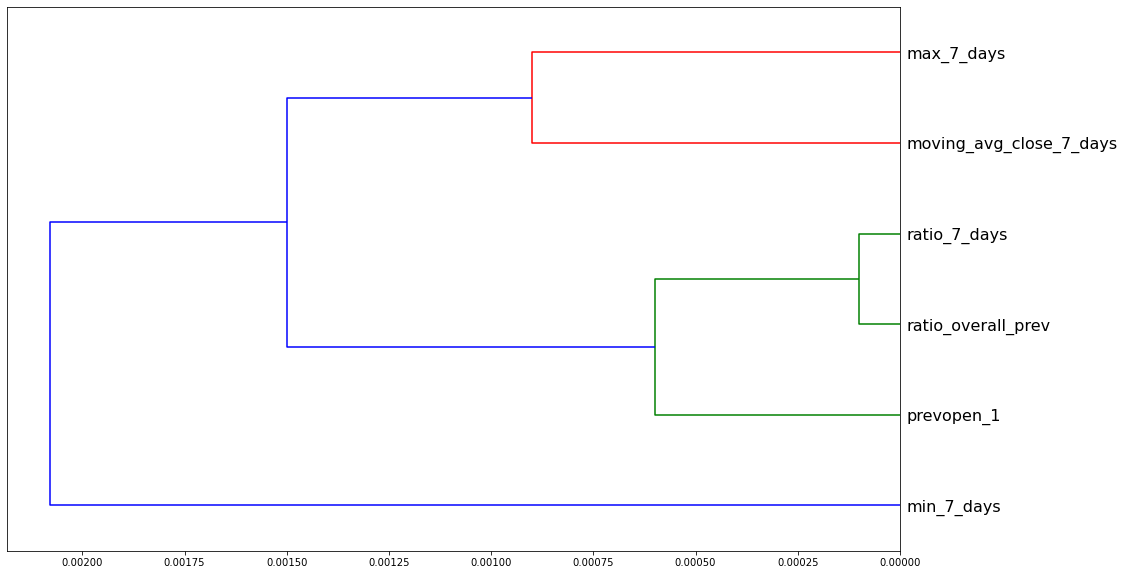

In [45]:
from scipy.cluster import hierarchy as hc

corr = np.round(sp.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [46]:
def get_oob(df):
    m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
    x, _, _ = split_vals(df, n_test)
    m.fit(x, y_train)
    return m.oob_score_

In [47]:
get_oob(df_keep)

0.9999675336187364

In [48]:
for c in ('ratio_7_days', 'ratio_overall_prev'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

ratio_7_days 0.9999104917689867
ratio_overall_prev 0.9997482180544518


### extrapolation

In [49]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_test] = 0

C:\Users\Gj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
X_ext, y_ext = df_ext.drop('is_valid', axis=1), df_ext.is_valid

In [51]:
X_train_ext, X_valid_ext, X_test_ext = split_vals(X_ext, n_test)
y_train_ext, y_valid_ext, y_test_ext = split_vals(y_ext, n_test)

In [52]:
model_ext = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_ext.fit(X_train_ext, y_train_ext)
model_ext.oob_score_

Wall time: 369 ms


0.8366862070116057

In [53]:
fi = rf_feat_importance(model_ext, X_train_ext); fi[:10]

,cols,imp
4,moving_avg_close_7_days,0.543095
2,prevopen_1,0.164697
5,max_7_days,0.108427
3,min_7_days,0.074448
0,ratio_overall_prev,0.059911
1,ratio_7_days,0.049421


In [54]:
feats=['moving_avg_close_7_days']
(X_train_ext[feats]/1000).describe()

,moving_avg_close_7_days
count,8594.000000
mean,4.427299
std,2.926976
min,0.500000
25%,1.842750
50%,4.203643
75%,5.415143
max,13.892714


In [55]:
X_train_ext.columns

Index(['ratio_overall_prev', 'ratio_7_days', 'prevopen_1', 'min_7_days',
       'moving_avg_close_7_days', 'max_7_days'],
      dtype='object')

In [56]:
X_train_ext.drop(feats, axis=1, inplace=True)
m_drop = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
m_drop.fit(X_train_ext, y_train_ext);
m_drop.oob_score_

0.6961302822495011

In [57]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train_sub, X_valid_sub, X_test_sub = split_vals(df_subs, n_test)
    m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
    m.fit(X_train_sub, y_train_ext)
    print(f)
    print_score(m, X_train_sub, y_train_ext, X_valid_sub, y_valid_ext)

moving_avg_close_7_days
[0.012097580353051618, 0.0, 0.8201757628566915, 1.0, 0.6907658760341517]


### final model

In [58]:
X, y = alk_df.drop(['close'], axis=1), alk_df.close_shift

In [59]:
X_train, X_valid, X_test = split_vals(X, n_test)
y_train, y_valid, y_test = split_vals(y, n_test)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8594, 30), (7, 30), (7, 30), (8594,), (7,), (7,))

In [60]:
model_final = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_final.fit(X_train, y_train)
print_score(model_final, X_train, y_train, X_valid, y_valid)

Wall time: 1.33 s
[3.439933358164167, 26.074000117796807, 0.9999986231707262, 0.9034410996376796, 0.999988869923077]


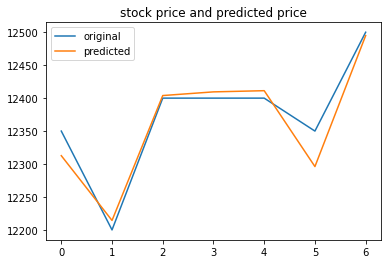

In [61]:
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="original")
plt.plot(x_ax, model_final.predict(X_valid), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [62]:
ranfor_pred = model_final.predict(X_test)

In [92]:
print('Test score:',model_final.score(X_test, y_test), '\n','Test RMSE:',rmse(ranfor_pred, y_test))

Test score: 0.9930112995866657 
 Test RMSE: 6.099004602626396


In [93]:
print('Difference on 7th day predictid price with actual is ',rmse(ranfor_pred[-1], np.array(y_test)[-1]))

Difference on 7th day predictid price with actual is  6.899999999999636


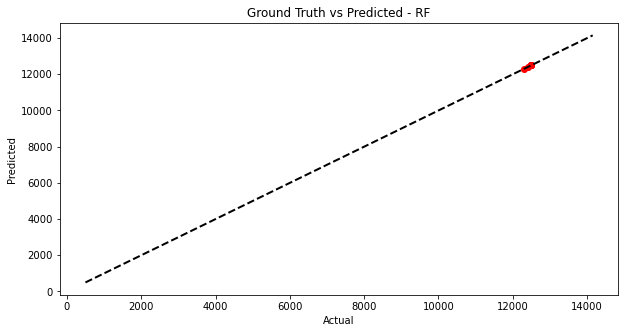

In [94]:
plt.figure(figsize=(10,5))

plt.scatter(y_test, ranfor_pred, color='red')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - RF')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()

### qty forecast

In [95]:
alk_df_qty = df_7_days[df_7_days.stock_id == 'ALK']
alk_df_qty = alk_df_qty.dropna()
to_drop_qty = ['date', 'start_date','stock_id', 'open', 'high', 'low', 'average', 'volume', 'close', 'change %', 'volume total']
alk_df_qty.drop(to_drop_qty, axis=1, inplace=True)

In [96]:
alk_df_qty['qty_30'] = alk_df_qty.quantity.shift(30)

In [97]:
alk_df_qty = alk_df_qty.dropna()

In [98]:
X_qty, y_qty = alk_df_qty.drop(['quantity', 'qty_30'], axis=1), alk_df_qty.qty_30

In [99]:
X_train_qty, X_valid_qty, X_test_qty = split_vals(X_qty, n_test)
y_train_qty, y_valid_qty, y_test_qty = split_vals(y_qty, n_test)
X_train_qty.shape, X_valid_qty.shape, X_test_qty.shape, y_train_qty.shape, y_valid_qty.shape, y_test_qty.shape

((8571, 29), (7, 29), (7, 29), (8571,), (7,), (7,))

In [100]:
#%%time

#parametars = {
#    'n_estimators': [30, 50, 100, 150, 200, 300, 400, 500],
#    'min_samples_leaf': [1, 3, 5, 10, 25]
#}
#
#model_qty = RandomForestRegressor(n_jobs=-1, max_features=0.5)
#clf = GridSearchCV(model_qty, parametars)
#clf.fit(X_train, y_train)

#print(f'Best params: {clf.best_params_}')
#print(f'Best score = {clf.best_score_}')

In [101]:
model_qty = RandomForestRegressor(n_jobs=-1, n_estimators=300, min_samples_leaf=1, max_features=0.5, oob_score=True)
%time model_qty.fit(X_train_qty, y_train_qty)
print_score(model_qty, X_train_qty, y_train_qty, X_valid_qty, y_valid_qty)

Wall time: 11.3 s
[185.16120787278862, 145.8909135306022, 0.8890488502987521, -0.8901559245928322, 0.19598984714037992]


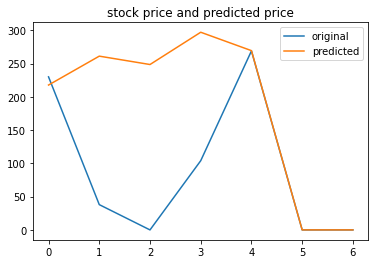

In [102]:
x_ax = range(len(y_valid_qty))
plt.plot(x_ax, y_valid_qty, label="original")
plt.plot(x_ax, model_qty.predict(X_valid_qty), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [103]:
ranfor_pred_qty = model_qty.predict(X_test_qty)

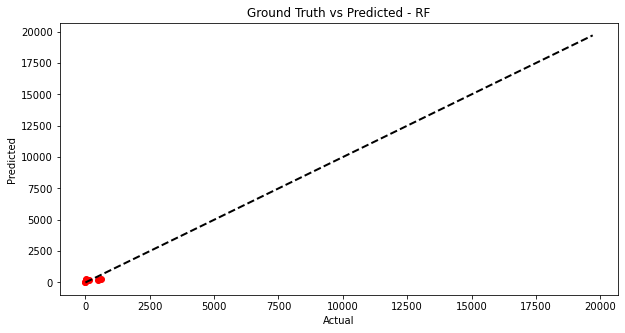

In [104]:
plt.figure(figsize=(10,5))

plt.scatter(y_test_qty, ranfor_pred_qty, color='red')
plt.plot([y_train_qty.min(), y_train_qty.max()], [y_train_qty.min(), y_train_qty.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - RF')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()

### XGBOOST

In [132]:
xgb_reg = xgb.XGBRegressor(colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7, 
                           learning_rate=0.05, n_estimators=400, 
                           gamma=0.02, max_depth=15)

In [133]:
xgb_reg.fit(X_train, y_train)
print_score(xgb_reg, X_train, y_train, X_valid, y_valid)

[0.16398230293735014, 47.059706593265204, 0.9999999968712274, 0.6854603384128515]


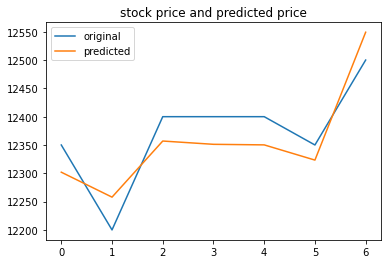

In [108]:
x_ax = range(len(y_valid))
plt.plot(x_ax, y_valid, label="original")
plt.plot(x_ax, xgb_reg.predict(X_valid), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [109]:
xgb_price = xgb_reg.predict(X_test)

In [110]:
xgb_reg.score(X_test, y_test)

0.7449559365002786

In [136]:
rmse(np.array(y_test)[-1], xgb_price[-1])

35.6875

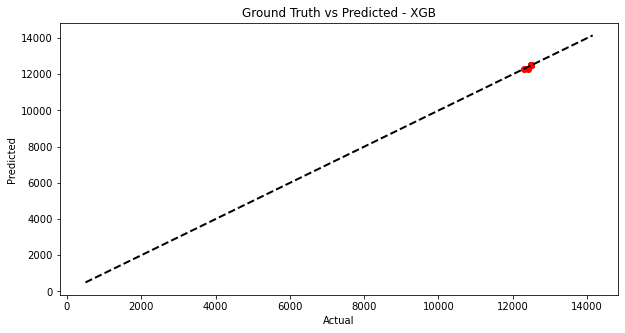

In [137]:
plt.figure(figsize=(10,5))

plt.scatter(y_test, xgb_price, color='red')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - XGB')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()

In [138]:
xgb_reg_qty = xgb.XGBRegressor(colsample_bylevel=0.7, colsample_bynode=0.7, colsample_bytree=0.7, 
                           learning_rate=0.05, n_estimators=400, 
                           gamma=0.02, max_depth=15)

In [139]:
xgb_reg_qty.fit(X_train_qty, y_train_qty)
print_score(xgb_reg_qty, X_train_qty, y_train_qty, X_valid_qty, y_valid_qty)

[7.085109960184517, 139.12908666992163, 0.9998375480285328, -0.7190044966937463]


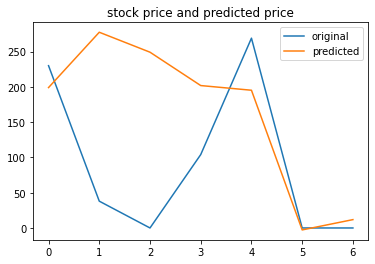

In [140]:
x_ax = range(len(y_valid_qty))
plt.plot(x_ax, y_valid_qty, label="original")
plt.plot(x_ax, xgb_reg_qty.predict(X_valid_qty), label="predicted")
plt.title("stock price and predicted price")
plt.legend()
plt.show()

In [141]:
xgb_qty = xgb_reg_qty.predict(X_test_qty)

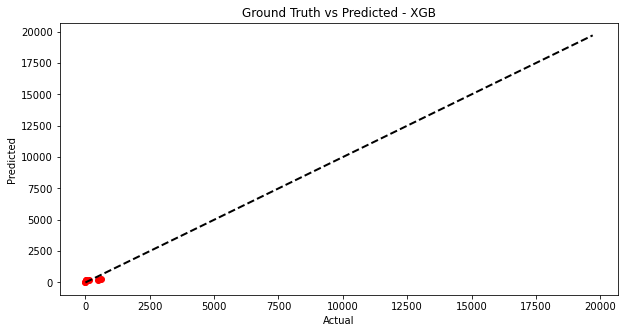

In [142]:
plt.figure(figsize=(10,5))

plt.scatter(y_test_qty, xgb_qty, color='red')
plt.plot([y_train_qty.min(), y_train_qty.max()], [y_train_qty.min(), y_train_qty.max()], 'k--', lw=2)
plt.title('Ground Truth vs Predicted - XGB')
plt.xlabel(xlabel='Actual')
plt.ylabel(ylabel='Predicted')
plt.show()